In [137]:
! pip install polytope notebook ipywidgets ipympl > /dev/null
import cvxpy as cp
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import control as ctrl
import polytope as pc


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [138]:
from scipy.special import gamma

def ellipsoid_volume(P, c):
    # Compute the volume of the hyperellipsoid x' P x <= c
    # Note that P must be square and c must be positive

    assert c > 0, "c must be positive"
    assert P.shape[0] == P.shape[1], "P must be square"
    
    # Check if P is a square matrix
    n = P.shape[0]
    P_ = P / c
    # Compute the determinant of P
    det_P = np.linalg.det(P_)
    # Compute the volume
    volume = (np.pi ** (n / 2)) / gamma(n / 2 + 1) / np.sqrt(det_P)
    return volume

FHOCP formulation
----

Note:
* State constraints are assumed to be in the form $A_x x_k \leq b_x$
* Input constraints are assumed to be in the form $A_u u_k \leq b_u$
* The adopted terminal cost is $p(x_N) = x_N^T P x_N$
* The terminal set is the $c_f$ level curve of the terminal cost, $\mathbb{X}_f = \{ x: x^T P x \leq c_f \}$

In [148]:
class FiniteHorizon:
    def __init__(self, A, B, Q, R, P, N, Ax=None, bx=None, Au=None, bu=None, c=None):
        self.N = N
        n, m = B.shape
        
        # Setting up the optimization variables
        self.U = cp.Variable((m, N)) # [ u_0, ..., u_{N-1} ]
        self.X = cp.Variable((n, N+1)) # [ x_0, ..., x_N ]
        self.x0 = cp.Parameter(n) # Placeholder for the initial state; it is set when calling solve.
        
        # Setting up the finite-horizon criterion
        criterion = cp.quad_form(self.X[:, N], P)
        for k in range(N):
            criterion += cp.quad_form(self.X[:, k], Q)+cp.quad_form( self.U[:, k], R)

        # Setting up constraints
        constraints = []
        constraints.append( self.X[:, 0] == self.x0 ) # x0 == x(0)
        constraints.append( self.X[:, 1:N+1] == A@self.X[:, 0:N] + B@self.U ) # x_{k+1} = A x_k + B u_k, k=0, ..., N-1

        # If polytopic state constraints are provided, add them to the constraints list
        if (Ax is not None and bx is not None):
            constraints.append(Ax @ self.X <= bx) # Ax @ x <= bx

        # If polytopic input constraints are provided, add them to the constraints list
        if (Au is not None and bu is not None):
            constraints.append(Au @ self.U <= bu)

        # If the quadratic terminal constraint is provided, add it to the constraints list
        if (c is not None):
            constraints.append(cp.quad_form(self.X[:, [-1]], P) <= c)
        
        # Minimization problem
        self.prob = cp.Problem(cp.Minimize(criterion),constraints)

    
    def solve(self, x0, verbose=False):
        self.x0.value = x0.flatten()
        self.prob.solve(verbose=verbose, solver = cp.CLARABEL)
        
        if self.prob.status == cp.INFEASIBLE:
            raise ValueError("The problem is infeasible")

        return self.U.value, self.X.value

System
----
$$x_{k+1} = \begin{bmatrix} 1 & 1 \\ 0 & 2\end{bmatrix} x_{k} +  \begin{bmatrix} 0 \\ 1 \end{bmatrix} u_k$$

The constraints are $x \in [-3, 3]^n$ and $u \in [2, 2]$, that is (polytope)

$$ \underbrace{\begin{bmatrix} 1 & 0 \\ 0 & 1 \\ -1 & 0 \\ 0 & -1 \end{bmatrix}}_{A_x} x \leq \underbrace{\begin{bmatrix} 3 \\ 3 \\ 3 \\ 3 \end{bmatrix}}_{b_x}$$
$$ \underbrace{\begin{bmatrix} 1 \\ -1 \end{bmatrix}}_{A_u} u \leq \underbrace{\begin{bmatrix} 2 \\ 2 \end{bmatrix}}_{b_u}$$

In [60]:
A = np.array([[1, 1], [0, 2]])
B = np.array([[0], [1]])

m = B.shape[1]
print(m)
n = A.shape[0]
print(n)

Ax = np.concatenate((np.eye(n), -np.eye(n)), axis=0)
bx = 3 * np.ones((2*n, 1))
Au = np.concatenate((np.eye(m), -np.eye(m)), axis=0)
bu = 2 * np.ones((2*m, 1))

1
2


Problem statement of the assignment
$$x_{k+1} = \begin{bmatrix} 1 & 0.1 \\ -0.5 & 0.8\end{bmatrix} x_{k} +  \begin{bmatrix} 0 \\ 0.1 \end{bmatrix} u_k$$

The constraints are $x \in [-3, 3]^n$ and $u \in [2, 2]$, that is (polytope)

$$ \underbrace{\begin{bmatrix} 1 & 0 \\ 0 & 1 \\ -1 & 0 \\ 0 & -1 \end{bmatrix}}_{A_x} x \leq \underbrace{\begin{bmatrix} 5 \\ 2 \\ 5 \\ 2 \end{bmatrix}}_{b_x}$$
$$ \underbrace{\begin{bmatrix} 1 \\ -1 \end{bmatrix}}_{A_u} u \leq \underbrace{\begin{bmatrix} 1 \\ 1 \end{bmatrix}}_{b_u}$$


In [61]:
A = np.array([[1, 0.1], [-0.5, 0.8]])
B = np.array([[0], [0.1]])

m = B.shape[1]
print(m)
n = A.shape[0]
print(n)

Ax = np.concatenate((np.eye(n), -np.eye(n)), axis=0)
bx = np.array([[5],[2],[5],[2]])
Au = np.concatenate((np.eye(m), -np.eye(m)), axis=0)
bu = np.ones((2*m, 1))

1
2


* We take $Q = I$ and $R = 0.1$. For the sake of illustration we take $N=4$
* We solve the Discrete Algebraic Riccati Equation (DARE) and find the $\text{LQ}_\infty$ gain $L$

In [62]:
Q = np.eye(n)
R = 1 * np.eye(m)

P, _, L = ctrl.dare(A, B, Q, R)
print(L)

[[0.00156 0.32199]]


## Terminal set definition
Now we have the auxiliary control law $u = -Lx$ and its Lyapunov function $p(x) = x^T P x$. 

The biggest possible terminal set $\mathbb{X}_f$ is the positive invariant set such that:
$$x \in \mathbb{X}_f \subseteq \mathbb{X} \quad \implies \quad -L x \in \mathbb{U} \wedge (A - BL) x \in \mathbb{X}_f$$

This set does not have a closed-form expression, so we need to compute it numerically (see *Example 10.1* of *Borrelli et al. 2017*)

In [63]:
# Represent the Ax x <= bx and Au (- Lx) <= bu constraints as polytopes for plotting purposes
x_constr = pc.Polytope(Ax, bx)
u_constr = pc.Polytope(Au @ (-L), bu)

# Intersect the polytopes
xu_constr = x_constr.intersect(u_constr)

In [ ]:
# Interative numerical computation of the invariant set (we will call it Omega here, to avoid confusion)
def polytopic_invariant_set_iterative(A, B, L, X_constraint, U_constraint, N_step) -> pc.Polytope:
    Omega = X_constraint.intersect(U_constraint)

    for i in range(N_step):
        A_cl = A - B @ L
        A_omega_i = Omega.A @ A_cl
        b_omega_i = Omega.b

        Omega = Omega.intersect(pc.Polytope(A_omega_i, b_omega_i))
    
    return Omega

Omega = polytopic_invariant_set_iterative(A, B, L, x_constr, u_constr, 100)
OV = Omega.volume
print(type(Omega))

<class 'polytope.polytope.Polytope'>


Here we have a Lyapunov function of the unconstrained system, so the easiest solution to find an invariant terminal set is to take the maximum level curve that lies within constraints.

Manifold of these candidate terminal sets: $\mathbb{X}_P^{c} = \{ x^T P x \leq c \}$

* Note that $\mathbb{X}_P^{c}$ is surely control invariant (it's a level curve of the Lyapunov function!)
* Find the maximum $c$ so that all $x \in \mathbb{X}_P^{c}$ satisfy  
    - $x \in \mathbb{X} \quad \Leftrightarrow \quad A_x x \leq b_x$
    - $u\in \mathbb{U} \quad \Leftrightarrow \quad (- A_u L) x \leq b_u$

In [ ]:
# To find the level sets of the Lyapunov function, we will evaluate p(x) on a grid
x1 = np.linspace(-bx[0], bx[0], 300)
print(max(x1), min(x1))
x2 = np.linspace(-bx[1], bx[1], 300)
X1, X2 = np.meshgrid(x1, x2)
XX = np.hstack([X1.reshape(-1, 1), X2.reshape(-1, 1)])

# Compute p(x1, x2) for the grid using the quadratic form
Lyap = P[0,0] * X1**2 + 2 * P[0,1] * X1 * X2 + P[1,1] * X2**2

[5.] [-5.]
[[573.06863 565.9013  558.7803  ... 480.48882 487.07904 493.71558]
 [572.59336 565.4278  558.30857 ... 480.54078 487.13278 493.77109]
 [572.11949 564.95571 557.83825 ... 480.59416 487.18792 493.82801]
 ...
 [493.82801 487.18792 480.59416 ... 557.83825 564.95571 572.11949]
 [493.77109 487.13278 480.54078 ... 558.30857 565.4278  572.59336]
 [493.71558 487.07904 480.48882 ... 558.7803  565.9013  573.06863]]


Let's plot all these sets to see how they look like!

Legend: 
* Light-blue area: $\mathbb{X}$ (state constraint)
* Red area: $\{ x: -Lx \in \mathbb{U} \}$ (states where the auxiliary control law is feasible)
* Green area: biggest possible $\mathbb{X}_f$ (computed numerically, see above)
* Elliptical lines: level curves of the Lyapunov function $p(x) = x^T P x$

If we go for the terminal set $\mathbb{X}_P^{c}$, what is the largest $c$ we can take?

Volume of Elipsoid with C=15 5.351215632827731
Volume of the Invariant set 10.536942239424814
Percentage of EV in OV:  50.78528012430142


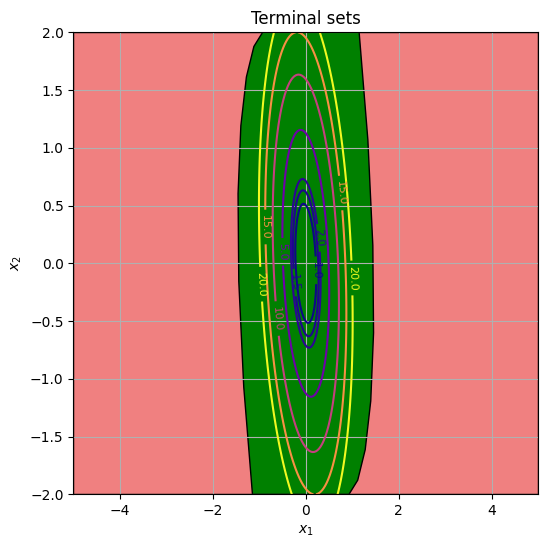

In [140]:
# Plot the level curves
f, ax = plt.subplots(figsize=(6,6))
# Plot the polytope with a pastel light blue color
x_constr.plot(ax=ax, color='lightblue', linestyle='solid', linewidth=1)
# plot_convex_hull(XX_feasible, ax, color='gray')
xu_constr.plot(ax=ax, color='lightcoral', linestyle='solid', linewidth=1)
Omega.plot(ax=ax, color='green', linestyle='solid', linewidth=1)
contour = ax.contour(X1, X2, Lyap, levels=[1, 1.5, 2, 5, 10, 15, 20], cmap='plasma')
EV = ellipsoid_volume(P, 15)
print("Volume of Elipsoid with C=15", EV)
print("Volume of the Invariant set", OV)
print("Percentage of EV in OV: ", EV/OV*100)
plt.clabel(contour, inline=True, fontsize=8)
plt.title(r'Terminal sets')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
#plt.xlim([-10,10])
#plt.ylim([-4,4])
plt.grid(True)
plt.show()

Answer: $c = 15$

$\mathbb{X}_P^{15}$ is a lot stricter than the maximum invariant set (green polytope), but it's really easy to compute!

Visualizing the trajectories
----

In [141]:
# Some plotting utility function! 
from matplotlib.patches import Ellipse

from matplotlib.collections import LineCollection 
def plot_convex_hull(invariant_points, ax, color='g'):
    hull = sp.spatial.ConvexHull(invariant_points)
    polyhull = pc.qhull(hull.points[hull.vertices, :])
    polyhull.plot(ax=ax, color=color, linestyle='solid', linewidth=1, alpha=0.7)

def colored_line_between_pts(x, y, c, ax, marker=None, **lc_kwargs):
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, **lc_kwargs)
    lc.set_array(c)
    ax.add_collection(lc)

    if marker is not None:
        cmap = lc_kwargs.get('cmap', None)
        ax.scatter(x, y, c=c, marker=marker, cmap=cmap)
    
    return

def plot_ellipse(A, c, ax):
    A_ = A / c
    Lambda, V = np.linalg.eig(A_)
    idx = np.argsort(Lambda)
    Lambda = Lambda[idx]
    V = V[:, idx]

    a = 2 / np.sqrt(Lambda[0])  # Corresponds to the smallest eigenvalue
    b = 2 / np.sqrt(Lambda[1])  # Corresponds to the largest eigenvalue

    angle = np.degrees(np.arctan2(V[1, 0], V[0, 0]))

    ellipse = Ellipse((0, 0), width=a, height=b, angle=angle, edgecolor='g', facecolor='none', linewidth=2)

    # Add the ellipse to the plot
    ax.add_patch(ellipse)

In [149]:
# A utility function that solves the FHOCP and, after the horizon, happends the state evolution under the auxiliary control law
def compute_trajectory(x0, fh: FiniteHorizon, N_sim):
    N = fh.N
    if x0.ndim == 1:
        x0 = x0.reshape(-1, 1)

    x = np.zeros((fh.X.shape[0], N + N_sim + 1))
    u = np.zeros((fh.U.shape[0], N + N_sim))

    x[:, 0] = x0.flatten()

    # Solve the FHOCP to get the state trajectory up to the prediction horizon N
    _u, _x = fh.solve(x0, verbose=False)
    u[:, :N] = _u
    x[:, :N+1] = _x

    # After N, apply the LQR for inf
    #LQR
    for k in range(N, N + N_sim):
        u[:, [k]] = -L @ x[:, [k]]
        x[:, [k+1]] = A @ x[:, [k]] + B @ u[:, [k]]
        
    col = np.concat([np.zeros(N,), np.ones(x.shape[1] - N,)])
    return x, u, col

We need to guarantee:
1) Recursive Feasability
2) Closed-Loop stability

Here, if we are able to find the invaraint set under the first N iterations using the Finite Horizon Optimal Control Problem (FHOCP), then we are able to fulfill 1) and 2) for LQR --> the last 20 iterations we apply LQR.

In [153]:
# We pick the biggest c that lies within the set of states (red polytope)
c_selected = 15 #Our ellipse of invariant set
N = 7
fh = FiniteHorizon(A, B, Q, R, P, N, Ax, bx, Au, bu, c=c_selected)
x_sim1, u_sim1, col_1 = compute_trajectory(np.array([1.5, 0]), fh, N)

<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_6409/219283547.py:5: SyntaxWarning: invalid escape sequence '\m'
  ax2.text(0.5, 0.5, '$\mathbb{X}_f$', fontsize=18, ha='left', color='green')
/tmp/ipykernel_6409/219283547.py:6: SyntaxWarning: invalid escape sequence '\m'
  ax2.text(-2.9, 2.6, '$\mathbb{X}$', fontsize=18, ha='left', color='tab:blue')


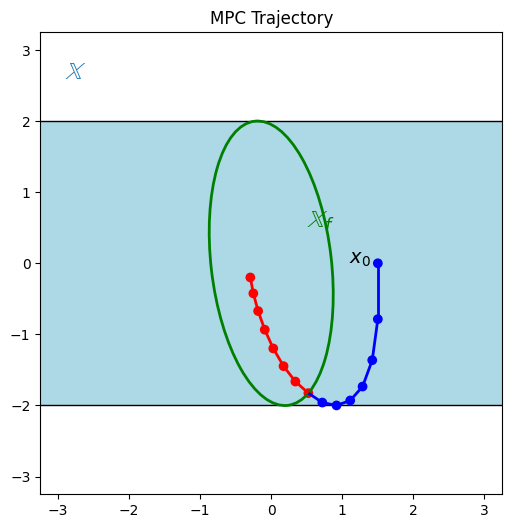

In [154]:
f, ax2 = plt.subplots(figsize=(6,6))
x_constr.plot(ax=ax2, color='lightblue', linestyle='solid', linewidth=1)
colored_line_between_pts(x_sim1[0, :], x_sim1[1, :], col_1, ax2, marker='o', cmap='bwr', linewidth=2, linestyle='-')
ax2.text(x_sim1[0, 0] - 0.1, x_sim1[1, 0], '$x_0$', fontsize=14, ha='right')
ax2.text(0.5, 0.5, '$\mathbb{X}_f$', fontsize=18, ha='left', color='green')
ax2.text(-2.9, 2.6, '$\mathbb{X}$', fontsize=18, ha='left', color='tab:blue')
ax2.set_aspect('equal', 'box')
ax2.set_xlim(-3.25, 3.25)
ax2.set_ylim(-3.25, 3.25)
ax2.set_title('MPC Trajectory')

# ax2.legend()
plot_ellipse(P,c_selected, ax2)